In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import  RBF


import Bgolearn.BGOsampling as BGOS 

 Bgolearn : A Bayesian global optimization package 
 10 Jul 2022, version 1, Bin Cao, MGI, SHU, Shanghai, CHINA.


In [3]:
def True_function(X):
    X = np.array(X)
    Y = 0.013*X**4 - 0.25*X**3 + 1.61*X**2 - 4.1*X + 8
    return Y

In [4]:
def generate_function(data, obs):
    print('------------12 original data-----------')
    data = np.array(data)
    # for one feature dataset
    data_matrix = np.array(data[:,0]).reshape(-1, 1)

    Measured_response = np.zeros(len(data_matrix))
    for i in range(obs):
        Measured_response += np.array(data[:,i+1])
    # for one feature dataset
    Measured_response = Measured_response/obs
    
    Measured_std = []
    for j in range(len(data_matrix)):
        std = np.std(np.array(data[j,1:1+obs]))
        Measured_std.append(std)
    Measured_std = np.array(Measured_std)  
    print('evaluated mean of y :', Measured_response)
    print('evaluated std of y :', Measured_std)
    print('---------------------------------------\n')
    return data_matrix,Measured_response,Measured_std

## design virtual samples

In [5]:
virtual_samples = np.linspace(0,11,100)

## define a callable Kriging model and sampling function

In [6]:
def Sam_function(X,real_std,obs):
    print('--------------Draw samples-------------')
    print('real std of added datum:', real_std)
    X = np.array(X)
    Y = np.zeros(1)
    Y_list = []
    for i in range(obs):
        __sam = 0.013*X**4 - 0.25*X**3 + 1.61*X**2 - 4.1*X + 8 + np.random.normal(loc=0.0, scale=real_std, size=None)
        Y_list.append(__sam)
        Y += __sam
        print(i+1,'-th sampling, result = ', __sam)
    cal_std = np.std(np.array(Y_list))
    print('evaluated mean of added datum:', Y/obs)
    print('evaluated std of added datum:', cal_std)
    print('---------------------------------------\n')
    return Y/obs, np.array(cal_std), np.array(Y_list)


## instantiate Bgolearn

In [7]:
Bgolearn = BGOS.Bgolearn()
method_name = 'EQI'


------------12 original data-----------
evaluated mean of y : [6.38302126 5.47159103 4.62333861 4.45561327 4.45288222 4.66633633
 4.60958967 4.62022357 4.74050698 4.45448135 5.94232697 7.79008494]
evaluated std of y : [0.31854553 0.36548063 0.05840252 0.72653212 0.30438189 0.24369472
 0.0862756  0.38254565 0.23908561 0.10964916 0.20850551 0.21403299]
---------------------------------------

current optimal is : 4.423457638847608
The next datum recomended by Expected Quantile Improvement : 
 x =  [8.44444444]
--------------Draw samples-------------
real std of added datum: 0.2
1 -th sampling, result =  4.067833219369049
2 -th sampling, result =  3.7825694600994013
3 -th sampling, result =  3.416879260850598
4 -th sampling, result =  3.825758531807896
5 -th sampling, result =  3.5072661309581865
evaluated mean of added datum: [3.72006132]
evaluated std of added datum: 0.23376296354333745
---------------------------------------

1-th iteration 
 new added datum: [8.4, array([3.7201])]


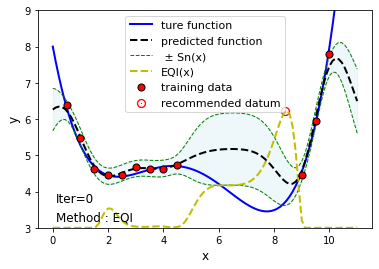

current optimal is : 3.787431036602518
The next datum recomended by Expected Quantile Improvement : 
 x =  [8.11111111]
--------------Draw samples-------------
real std of added datum: 0.7
1 -th sampling, result =  4.749857577628631
2 -th sampling, result =  2.536958242932364
3 -th sampling, result =  1.9080031917643827
4 -th sampling, result =  2.9832499512833004
5 -th sampling, result =  3.513737752482557
evaluated mean of added datum: [3.13836134]
evaluated std of added datum: 0.9630528517107928
---------------------------------------

2-th iteration 
 new added datum: [8.1, array([3.1384])]


<Figure size 432x288 with 0 Axes>

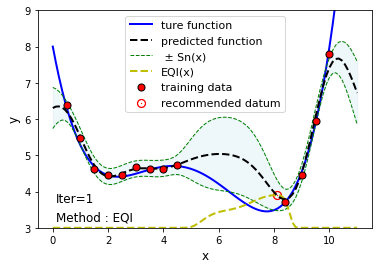

current optimal is : 3.3782331922883966
The next datum recomended by Expected Quantile Improvement : 
 x =  [7.55555556]
--------------Draw samples-------------
real std of added datum: 0.4
1 -th sampling, result =  3.8491996066342216
2 -th sampling, result =  2.991373896390892
3 -th sampling, result =  3.557148886145687
4 -th sampling, result =  3.6037672793033684
5 -th sampling, result =  3.320460815832898
evaluated mean of added datum: [3.4643901]
evaluated std of added datum: 0.29002362477270194
---------------------------------------

3-th iteration 
 new added datum: [7.6, array([3.4644])]


<Figure size 432x288 with 0 Axes>

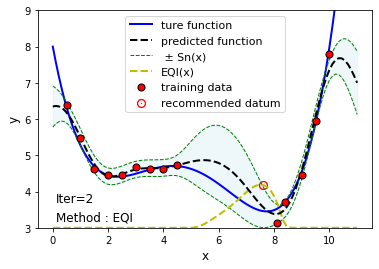

<Figure size 432x288 with 0 Axes>

In [11]:
obs = 5
guessed_noise_std = 0.3

data = pd.read_csv('data.csv')
data_matrix, Measured_response,Measured_std = generate_function(data,obs)
Y1=data.iloc[:,1:]

for i in range(500):
    plt.figure()
    ax1 = plt.subplot()
    ax1.set_ylim([3, 9])
    
   
    class Kriging_model(object):
        def fit_pre(self,xtrain,ytrain,xtest):
            # instantiated model
            kernel = RBF() 
            mdoel = GaussianProcessRegressor(kernel=kernel,normalize_y=True,alpha = guessed_noise_std**2).fit(xtrain,ytrain)
            # defined the attribute's outputs
            mean,std = mdoel.predict(xtest,return_std=True)
            return mean,std  
    

    y_mean_pre,y_mean_std = Kriging_model().fit_pre(data_matrix, Measured_response, virtual_samples.reshape(-1,1))
    ax1.scatter(data_matrix,Measured_response,c='r',s=50,zorder=10,edgecolors=(0,0,0),label="training data")
    ax1.plot(virtual_samples,True_function(virtual_samples),'b',lw=2,label="ture function")
    ax1.plot(virtual_samples,y_mean_pre,'k--',lw=2,zorder=9,label="predicted function")
    ax1.fill_between(virtual_samples,y_mean_pre-y_mean_std,y_mean_pre+y_mean_std,alpha=0.2,color='lightblue')
    ax1.plot(virtual_samples,y_mean_pre-y_mean_std,'g--',lw=1,label=' ± Sn(x)') 
    ax1.plot(virtual_samples,y_mean_pre+y_mean_std,'g--',lw=1)

    
    Bgolearn = BGOS.Bgolearn()
    # min_search = False:  searching the global maximum
    model = Bgolearn.fit(Kriging_model,data_matrix,Measured_response,virtual_samples,opt_num = 1,min_search = True)
    # recall the utility function 

    _return = model.EQI(beta = 0.5,tao_new = guessed_noise_std)*10 + 3
    
    index = np.random.choice(np.flatnonzero(_return == _return.max()))
    recommend = virtual_samples[index]
    ax1.plot(virtual_samples,_return,'y--',lw=2,label='{name}(x)'.format(name = method_name))
    
    # give an intrinsic std to recommended datum
    sam_std = round(random.uniform(0.1,0.7),1)
    datum_y, datum_std, Y_list = Sam_function(round(recommend,1),sam_std,obs)
    Measured_std = np.append(Measured_std,datum_std)
    data_matrix = np.append(data_matrix,np.round(recommend,1)).reshape(-1,1)
    Measured_response = np.append(Measured_response,np.round(datum_y,4))
    Y1 = np.append(Y1,Y_list)
 
    Measured_std1=(pd.DataFrame(Measured_std.reshape(len(Measured_std),1),columns=['Measured_std']))
    Measured_response1=(pd.DataFrame(Measured_response.reshape(len(Measured_std),1),columns=['Measured_response']))
    data_matrix1=(pd.DataFrame(data_matrix.reshape(len(data_matrix),1),columns=['x']))
    Y1=(pd.DataFrame(Y1.reshape(len(data_matrix),5)))
    data_iter=(np.hstack((data_matrix1,Measured_response1,Measured_std1,Y1)))
    
 
    
    print("{num}-th iteration".format(num = i + 1),'\n', 'new added datum:',([np.round(recommend,1),np.round(datum_y,4)]))
    ax1.scatter(round(recommend,1),_return[index],c='red',s=1.5,linewidths=8,label="recommended datum") 
    
    
    plt.text(0.1,3.2,'Method : {name}'.format(name = method_name),fontsize=12,color='k')
    plt.text(0.1,3.7,'Iter={}'.format(i),fontsize=12,color='k')
    plt.xlabel('x',fontsize = 12)
    plt.ylabel('y',fontsize = 12)
    plt.legend(fontsize = 11)
    plt.savefig('{name}-sd_{sdlevel}-obs_{obstime}-{num}.png'.format(name = method_name,sdlevel=guessed_noise_std,obstime = obs,num = i),dpi=800)
    plt.show()
    plt.clf()
    if 7.6 <= round(recommend,1) <= 7.8:
        break
    elif i>=10:
        print('Searching is defeated')
        break
data_iter=pd.DataFrame(data_iter.reshape(len(data_matrix),8),columns=['x','y_mean',"y_sd","y1","y2","y3","y4","y5"])
data_iter.to_csv('sd{:.2f}data.csv'.format(guessed_noise_std),float_format='%.4f') #保留两位小数


------------12 original data-----------
evaluated mean of y : [6.38302126 5.47159103 4.62333861 4.45561327 4.45288222 4.66633633
 4.60958967 4.62022357 4.74050698 4.45448135 5.94232697 7.79008494]
evaluated std of y : [0.31854553 0.36548063 0.05840252 0.72653212 0.30438189 0.24369472
 0.0862756  0.38254565 0.23908561 0.10964916 0.20850551 0.21403299]
---------------------------------------

current optimal is : 4.473667528516746
The next datum recomended by Expected Quantile Improvement : 
 x =  [8.33333333]
--------------Draw samples-------------
real std of added datum: 0.6
1 -th sampling, result =  2.6006783744243753
2 -th sampling, result =  4.009945673903447
3 -th sampling, result =  3.580179129461763
4 -th sampling, result =  3.3805973530921403
5 -th sampling, result =  3.8344030579253134
evaluated mean of added datum: [3.48116072]
evaluated std of added datum: 0.48980822243489297
---------------------------------------

1-th iteration 
 new added datum: [8.3, array([3.4812])]


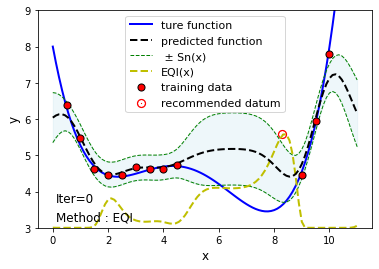

current optimal is : 3.7309341548096624
The next datum recomended by Expected Quantile Improvement : 
 x =  [8.11111111]
--------------Draw samples-------------
real std of added datum: 0.3
1 -th sampling, result =  3.373017333844843
2 -th sampling, result =  3.4101134299613967
3 -th sampling, result =  3.889876596820441
4 -th sampling, result =  3.947972674262738
5 -th sampling, result =  3.6255012999053378
evaluated mean of added datum: [3.64929627]
evaluated std of added datum: 0.2371460184148628
---------------------------------------

2-th iteration 
 new added datum: [8.1, array([3.6493])]


<Figure size 432x288 with 0 Axes>

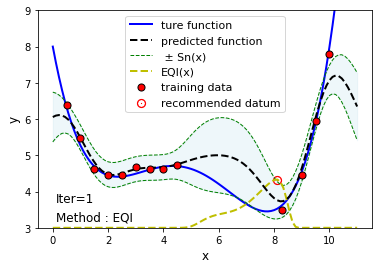

current optimal is : 3.683094156302033
The next datum recomended by Expected Quantile Improvement : 
 x =  [8.11111111]
--------------Draw samples-------------
real std of added datum: 0.6
1 -th sampling, result =  3.248336097063447
2 -th sampling, result =  2.307371465580938
3 -th sampling, result =  4.044342320566843
4 -th sampling, result =  2.6669692026939718
5 -th sampling, result =  4.179602587286088
evaluated mean of added datum: [3.28932433]
evaluated std of added datum: 0.737005415060176
---------------------------------------

3-th iteration 
 new added datum: [8.1, array([3.2893])]


<Figure size 432x288 with 0 Axes>

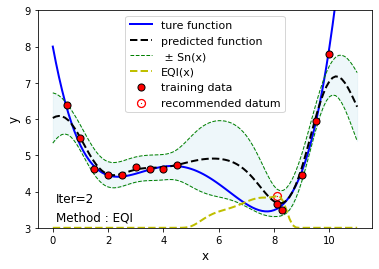

current optimal is : 3.5441851260262975
The next datum recomended by Expected Quantile Improvement : 
 x =  [7.33333333]
--------------Draw samples-------------
real std of added datum: 0.2
1 -th sampling, result =  3.6817138857764866
2 -th sampling, result =  3.4011101679130546
3 -th sampling, result =  3.339711947132824
4 -th sampling, result =  3.309216731042481
5 -th sampling, result =  3.655810483089356
evaluated mean of added datum: [3.47751264]
evaluated std of added datum: 0.15914656847980946
---------------------------------------

4-th iteration 
 new added datum: [7.3, array([3.4775])]


<Figure size 432x288 with 0 Axes>

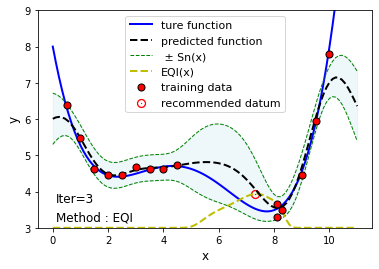

current optimal is : 3.4689681780396846
The next datum recomended by Expected Quantile Improvement : 
 x =  [7.77777778]
--------------Draw samples-------------
real std of added datum: 0.6
1 -th sampling, result =  3.1277497273244252
2 -th sampling, result =  4.064492499834812
3 -th sampling, result =  4.061944591719313
4 -th sampling, result =  3.4700691415441436
5 -th sampling, result =  3.8483054066209172
evaluated mean of added datum: [3.71451227]
evaluated std of added datum: 0.36472968274977446
---------------------------------------

5-th iteration 
 new added datum: [7.8, array([3.7145])]


<Figure size 432x288 with 0 Axes>

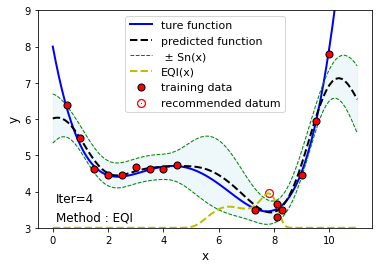

<Figure size 432x288 with 0 Axes>

In [9]:
obs = 5
guessed_noise_std = 0.5

data = pd.read_csv('data.csv')
data_matrix, Measured_response,Measured_std = generate_function(data,obs)
Y1=data.iloc[:,1:]

for i in range(500):
    plt.figure()
    ax1 = plt.subplot()
    ax1.set_ylim([3, 9])
    
   
    class Kriging_model(object):
        def fit_pre(self,xtrain,ytrain,xtest):
            # instantiated model
            kernel = RBF() 
            mdoel = GaussianProcessRegressor(kernel=kernel,normalize_y=True,alpha = guessed_noise_std**2).fit(xtrain,ytrain)
            # defined the attribute's outputs
            mean,std = mdoel.predict(xtest,return_std=True)
            return mean,std  
    

    y_mean_pre,y_mean_std = Kriging_model().fit_pre(data_matrix, Measured_response, virtual_samples.reshape(-1,1))
    ax1.scatter(data_matrix,Measured_response,c='r',s=50,zorder=10,edgecolors=(0,0,0),label="training data")
    ax1.plot(virtual_samples,True_function(virtual_samples),'b',lw=2,label="ture function")
    ax1.plot(virtual_samples,y_mean_pre,'k--',lw=2,zorder=9,label="predicted function")
    ax1.fill_between(virtual_samples,y_mean_pre-y_mean_std,y_mean_pre+y_mean_std,alpha=0.2,color='lightblue')
    ax1.plot(virtual_samples,y_mean_pre-y_mean_std,'g--',lw=1,label=' ± Sn(x)') 
    ax1.plot(virtual_samples,y_mean_pre+y_mean_std,'g--',lw=1)

    
    Bgolearn = BGOS.Bgolearn()
    # min_search = False:  searching the global maximum
    model = Bgolearn.fit(Kriging_model,data_matrix,Measured_response,virtual_samples,opt_num = 1,min_search = True)
    # recall the utility function 

    _return = model.EQI(beta = 0.5,tao_new = guessed_noise_std)*10 + 3
    
    index = np.random.choice(np.flatnonzero(_return == _return.max()))
    recommend = virtual_samples[index]
    ax1.plot(virtual_samples,_return,'y--',lw=2,label='{name}(x)'.format(name = method_name))
    
    # give an intrinsic std to recommended datum
    sam_std = round(random.uniform(0.1,0.7),1)
    datum_y, datum_std, Y_list = Sam_function(round(recommend,1),sam_std,obs)
    Measured_std = np.append(Measured_std,datum_std)
    data_matrix = np.append(data_matrix,np.round(recommend,1)).reshape(-1,1)
    Measured_response = np.append(Measured_response,np.round(datum_y,4))
    Y1 = np.append(Y1,Y_list)
 
    Measured_std1=(pd.DataFrame(Measured_std.reshape(len(Measured_std),1),columns=['Measured_std']))
    Measured_response1=(pd.DataFrame(Measured_response.reshape(len(Measured_std),1),columns=['Measured_response']))
    data_matrix1=(pd.DataFrame(data_matrix.reshape(len(data_matrix),1),columns=['x']))
    Y1=(pd.DataFrame(Y1.reshape(len(data_matrix),5)))
    data_iter=(np.hstack((data_matrix1,Measured_response1,Measured_std1,Y1)))
    
 
    
    print("{num}-th iteration".format(num = i + 1),'\n', 'new added datum:',([np.round(recommend,1),np.round(datum_y,4)]))
    ax1.scatter(round(recommend,1),_return[index],c='red',s=1.5,linewidths=8,label="recommended datum") 
    
    
    plt.text(0.1,3.2,'Method : {name}'.format(name = method_name),fontsize=12,color='k')
    plt.text(0.1,3.7,'Iter={}'.format(i),fontsize=12,color='k')
    plt.xlabel('x',fontsize = 12)
    plt.ylabel('y',fontsize = 12)
    plt.legend(fontsize = 11)
    plt.savefig('{name}-sd_{sdlevel}-obs_{obstime}-{num}.png'.format(name = method_name,sdlevel=guessed_noise_std,obstime = obs,num = i),dpi=800)
    plt.show()
    plt.clf()
    if 7.6 <= round(recommend,1) <= 7.8:
        break
    elif i>=10:
        print('Searching is defeated')
        break
data_iter=pd.DataFrame(data_iter.reshape(len(data_matrix),8),columns=['x','y_mean',"y_sd","y1","y2","y3","y4","y5"])
data_iter.to_csv('sd{:.2f}data.csv'.format(guessed_noise_std),float_format='%.4f') #保留两位小数


------------12 original data-----------
evaluated mean of y : [6.38302126 5.47159103 4.62333861 4.45561327 4.45288222 4.66633633
 4.60958967 4.62022357 4.74050698 4.45448135 5.94232697 7.79008494]
evaluated std of y : [0.31854553 0.36548063 0.05840252 0.72653212 0.30438189 0.24369472
 0.0862756  0.38254565 0.23908561 0.10964916 0.20850551 0.21403299]
---------------------------------------

current optimal is : 4.547688416227402
The next datum recomended by Expected Quantile Improvement : 
 x =  [8.33333333]
--------------Draw samples-------------
real std of added datum: 0.4
1 -th sampling, result =  3.473606918532137
2 -th sampling, result =  2.9517241417227726
3 -th sampling, result =  3.4188378975327907
4 -th sampling, result =  3.991046685190417
5 -th sampling, result =  3.544513984779418
evaluated mean of added datum: [3.47594593]
evaluated std of added datum: 0.33109081768767556
---------------------------------------

1-th iteration 
 new added datum: [8.3, array([3.4759])]


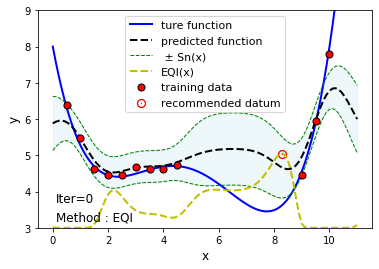

current optimal is : 3.9302390947463586
The next datum recomended by Expected Quantile Improvement : 
 x =  [8.]
--------------Draw samples-------------
real std of added datum: 0.7
1 -th sampling, result =  4.065527337010358
2 -th sampling, result =  3.3574018868446265
3 -th sampling, result =  3.665201620794755
4 -th sampling, result =  4.6829162571456475
5 -th sampling, result =  2.7040505483734387
evaluated mean of added datum: [3.69501953]
evaluated std of added datum: 0.6648473932844817
---------------------------------------

2-th iteration 
 new added datum: [8.0, array([3.695])]


<Figure size 432x288 with 0 Axes>

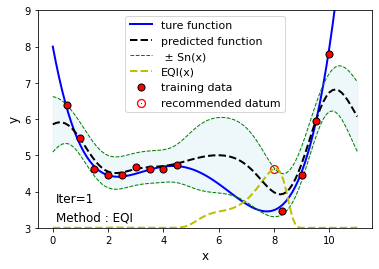

current optimal is : 3.820840906038759
The next datum recomended by Expected Quantile Improvement : 
 x =  [8.]
--------------Draw samples-------------
real std of added datum: 0.3
1 -th sampling, result =  4.0387432230214015
2 -th sampling, result =  3.3952640471331907
3 -th sampling, result =  2.689844657637951
4 -th sampling, result =  3.415427100417722
5 -th sampling, result =  3.605341658494008
evaluated mean of added datum: [3.42892414]
evaluated std of added datum: 0.43601745561995303
---------------------------------------

3-th iteration 
 new added datum: [8.0, array([3.4289])]


<Figure size 432x288 with 0 Axes>

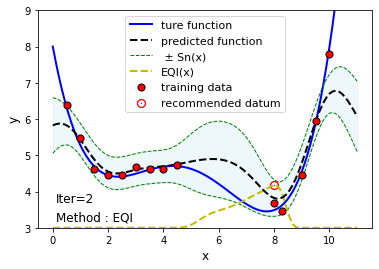

current optimal is : 3.6814156280627994
The next datum recomended by Expected Quantile Improvement : 
 x =  [7.55555556]
--------------Draw samples-------------
real std of added datum: 0.3
1 -th sampling, result =  3.579657470260001
2 -th sampling, result =  3.4813206446099865
3 -th sampling, result =  3.552715749134613
4 -th sampling, result =  2.9113076672630087
5 -th sampling, result =  3.5222406629480743
evaluated mean of added datum: [3.40944844]
evaluated std of added datum: 0.2512085048977432
---------------------------------------

4-th iteration 
 new added datum: [7.6, array([3.4094])]


<Figure size 432x288 with 0 Axes>

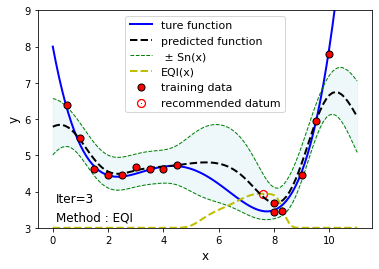

<Figure size 432x288 with 0 Axes>

In [10]:
obs = 5
guessed_noise_std = 0.7

data = pd.read_csv('data.csv')
data_matrix, Measured_response,Measured_std = generate_function(data,obs)
Y1=data.iloc[:,1:]

for i in range(500):
    plt.figure()
    ax1 = plt.subplot()
    ax1.set_ylim([3, 9])
    
   
    class Kriging_model(object):
        def fit_pre(self,xtrain,ytrain,xtest):
            # instantiated model
            kernel = RBF() 
            mdoel = GaussianProcessRegressor(kernel=kernel,normalize_y=True,alpha = guessed_noise_std**2).fit(xtrain,ytrain)
            # defined the attribute's outputs
            mean,std = mdoel.predict(xtest,return_std=True)
            return mean,std  
    

    y_mean_pre,y_mean_std = Kriging_model().fit_pre(data_matrix, Measured_response, virtual_samples.reshape(-1,1))
    ax1.scatter(data_matrix,Measured_response,c='r',s=50,zorder=10,edgecolors=(0,0,0),label="training data")
    ax1.plot(virtual_samples,True_function(virtual_samples),'b',lw=2,label="ture function")
    ax1.plot(virtual_samples,y_mean_pre,'k--',lw=2,zorder=9,label="predicted function")
    ax1.fill_between(virtual_samples,y_mean_pre-y_mean_std,y_mean_pre+y_mean_std,alpha=0.2,color='lightblue')
    ax1.plot(virtual_samples,y_mean_pre-y_mean_std,'g--',lw=1,label=' ± Sn(x)') 
    ax1.plot(virtual_samples,y_mean_pre+y_mean_std,'g--',lw=1)

    
    Bgolearn = BGOS.Bgolearn()
    # min_search = False:  searching the global maximum
    model = Bgolearn.fit(Kriging_model,data_matrix,Measured_response,virtual_samples,opt_num = 1,min_search = True)
    # recall the utility function 

    _return = model.EQI(beta = 0.5,tao_new = guessed_noise_std)*10 + 3
    
    index = np.random.choice(np.flatnonzero(_return == _return.max()))
    recommend = virtual_samples[index]
    ax1.plot(virtual_samples,_return,'y--',lw=2,label='{name}(x)'.format(name = method_name))
    
    # give an intrinsic std to recommended datum
    sam_std = round(random.uniform(0.1,0.7),1)
    datum_y, datum_std, Y_list = Sam_function(round(recommend,1),sam_std,obs)
    Measured_std = np.append(Measured_std,datum_std)
    data_matrix = np.append(data_matrix,np.round(recommend,1)).reshape(-1,1)
    Measured_response = np.append(Measured_response,np.round(datum_y,4))
    Y1 = np.append(Y1,Y_list)
 
    Measured_std1=(pd.DataFrame(Measured_std.reshape(len(Measured_std),1),columns=['Measured_std']))
    Measured_response1=(pd.DataFrame(Measured_response.reshape(len(Measured_std),1),columns=['Measured_response']))
    data_matrix1=(pd.DataFrame(data_matrix.reshape(len(data_matrix),1),columns=['x']))
    Y1=(pd.DataFrame(Y1.reshape(len(data_matrix),5)))
    data_iter=(np.hstack((data_matrix1,Measured_response1,Measured_std1,Y1)))
    
 
    
    print("{num}-th iteration".format(num = i + 1),'\n', 'new added datum:',([np.round(recommend,1),np.round(datum_y,4)]))
    ax1.scatter(round(recommend,1),_return[index],c='red',s=1.5,linewidths=8,label="recommended datum") 
    
    
    plt.text(0.1,3.2,'Method : {name}'.format(name = method_name),fontsize=12,color='k')
    plt.text(0.1,3.7,'Iter={}'.format(i),fontsize=12,color='k')
    plt.xlabel('x',fontsize = 12)
    plt.ylabel('y',fontsize = 12)
    plt.legend(fontsize = 11)
    plt.savefig('{name}-sd_{sdlevel}-obs_{obstime}-{num}.png'.format(name = method_name,sdlevel=guessed_noise_std,obstime = obs,num = i),dpi=800)
    plt.show()
    plt.clf()
    if 7.6 <= round(recommend,1) <= 7.8:
        break
    elif i>=10:
        print('Searching is defeated')
        break
data_iter=pd.DataFrame(data_iter.reshape(len(data_matrix),8),columns=['x','y_mean',"y_sd","y1","y2","y3","y4","y5"])
data_iter.to_csv('sd{:.2f}data.csv'.format(guessed_noise_std),float_format='%.4f') #保留两位小数
